In [2]:
# %%
# %%
import os
import sys
import numpy as np
# from torch.utils.data import TensorDataset, DataLoader

## Load model module
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/auxilary_modules') #TODO adjust path
sys.path.append('/projects/ecrpstats/distributional_SRCNN/auxilary_modules')
import data_loading

import matplotlib.pyplot as plt

import pandas as pd


train_or_load = 'load'
# %%
hr_data_size = 64
lr_data_size = 8
# %%
epochs = 300
batch_size = 32
##
num_sing_mode = 50
##
region = 0
subregion = 'all'

log_file_base_path = 'parCov_fitting'

save_path = f'{log_file_base_path}.pt'

## ~~~~~~~~~~~
## import data
xtrainHR, xtestHR, xtrainLR, xtestLR = data_loading.import_data(
    region,
    subregion,
    train_fraction=.75, 
    order='(subregion, time)'
    )

In [3]:
xtrainHR.shape

(642, 1, 64, 64)

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
targets = xtestHR.squeeze()

Define basis functions

In [6]:
N = 64
def compl_dft_basis(x, y, k_x, k_y):
    return np.exp(1j * 2*np.pi * (k_x*x + k_y*y)/N)

In [7]:
x = np.arange(0, N)

xg = np.tile(x, N)            # generates x-coordinates for the entire grid N*K 
yg = np.repeat(x, N, axis=0)

mat_xg = xg.reshape((64, 64))
mat_yg = yg.reshape((64, 64))

In [8]:
## Create basis functions to max period
# max_T = 20
# min_k = int(N/max_T)
min_k = 0
print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
print(f"max k : {max_k}")

basis_function_k_idx = []
basis_functions = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        basis_functions.append(
            compl_dft_basis(
                mat_xg, 
                mat_yg, 
                _kx, 
                _ky
                )
            )
        basis_function_k_idx.append((_kx, _ky))
        
basis_functions = np.asarray(basis_functions).reshape((-1, 64**2)).T / N
basis_functions.shape

min k : 0
max k : 33


(4096, 1089)

Functions for sample gen

In [9]:
def compute_sigma_svd(cov_params):
   
    Sigma = np.matmul(
        np.matmul(
            basis_functions, 
            np.diag(cov_params)
            ),
        np.conj(basis_functions.T)
        )
    
    u, s, vh = np.linalg.svd(np.real(Sigma))

    return u, s

def get_noise_from_cov_params_wSVD(u, s, n_samples=100):
    
    Z = np.random.randn(n_samples, hr_data_size**2)
    
    rescaled_noise = Z @ np.diag(s**0.5) @ u.T
    
    return rescaled_noise

In [10]:
## analytic results with correct downscaling
p5p5_cov_params = np.load(
    "../stage_2/output/parCov_fitting_fourier_allImages_mseStart_globalPrior_anal_empPriorStdOn5p5_param_fits.npy"
    )

p5p5_err = np.load(
    "../stage_3/output_data/fcov_GL_mseStart_gPAStdOn5p5_errFields.npy")

In [11]:
test_p5p5_cov_params = p5p5_cov_params[-214:]
test_p5p5_cov_params.shape

(214, 1089)

In [12]:
p5p5_pred = p5p5_err + targets

In [13]:
p5p5_pred.shape

(214, 64, 64)

# Load data

In [14]:
path_to_global_err_fields = "../stage_3/output_data/fcov_GL_mseStart_global_errFields.npy"
global_err_fields = np.load(path_to_global_err_fields)
global_err_fields.shape

(214, 64, 64)

In [15]:
## analytic results with correct downscaling
global_cov_params = np.load("../stage_2/anal_sln_global_params.npy")

In [16]:
global_u, global_s = compute_sigma_svd(global_cov_params)

In [17]:
global_pred = global_err_fields + targets


In [18]:
from skfda import FDataGrid


In [19]:
from skfda.exploratory.depth import ModifiedBandDepth

# Create the depth object
depth = ModifiedBandDepth()

In [20]:
targets.shape

(214, 64, 64)

In [22]:
global_50_coverage = []
p5p5_50_coverage = []

path_to_img_spec_noise = "/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/sr_ordered_train0p75/sample_generation/img_spec_noise_compute/kestrel_output/"

for i in range(targets.shape[0]):
    print(i)

    #### Get GLOBAL result
    ## resample noise
    g_noise = get_noise_from_cov_params_wSVD(global_u, global_s, n_samples=100)
    
    g_samples = g_noise + global_pred[i].ravel()[None, :]
    
    ## Compute surfaces
    fd = FDataGrid(g_samples.reshape((-1, hr_data_size, hr_data_size)))
    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    global_50_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    ## Get IMG-SPE result
    is_noise = np.load(path_to_img_spec_noise + f"p5p5_img_{642+i}_noise_samples.npy") 
    is_samples = p5p5_pred[i].ravel()[None, :] + is_noise
    
    fd = FDataGrid(is_samples.reshape((-1, hr_data_size, hr_data_size)))

    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    p5p5_50_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    # if i == 10:
    #     break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213


In [23]:
global_50_coverage = np.asarray(global_50_coverage)
p5p5_50_coverage = np.asarray(p5p5_50_coverage)

In [24]:
np.save('global_coverage_50per.npy', global_50_coverage)
np.save('p5p5_coverage_50per.npy', p5p5_50_coverage)

In [29]:
p2p5_50_coverage.shape

(214,)

(0.4, 1.016669921875)

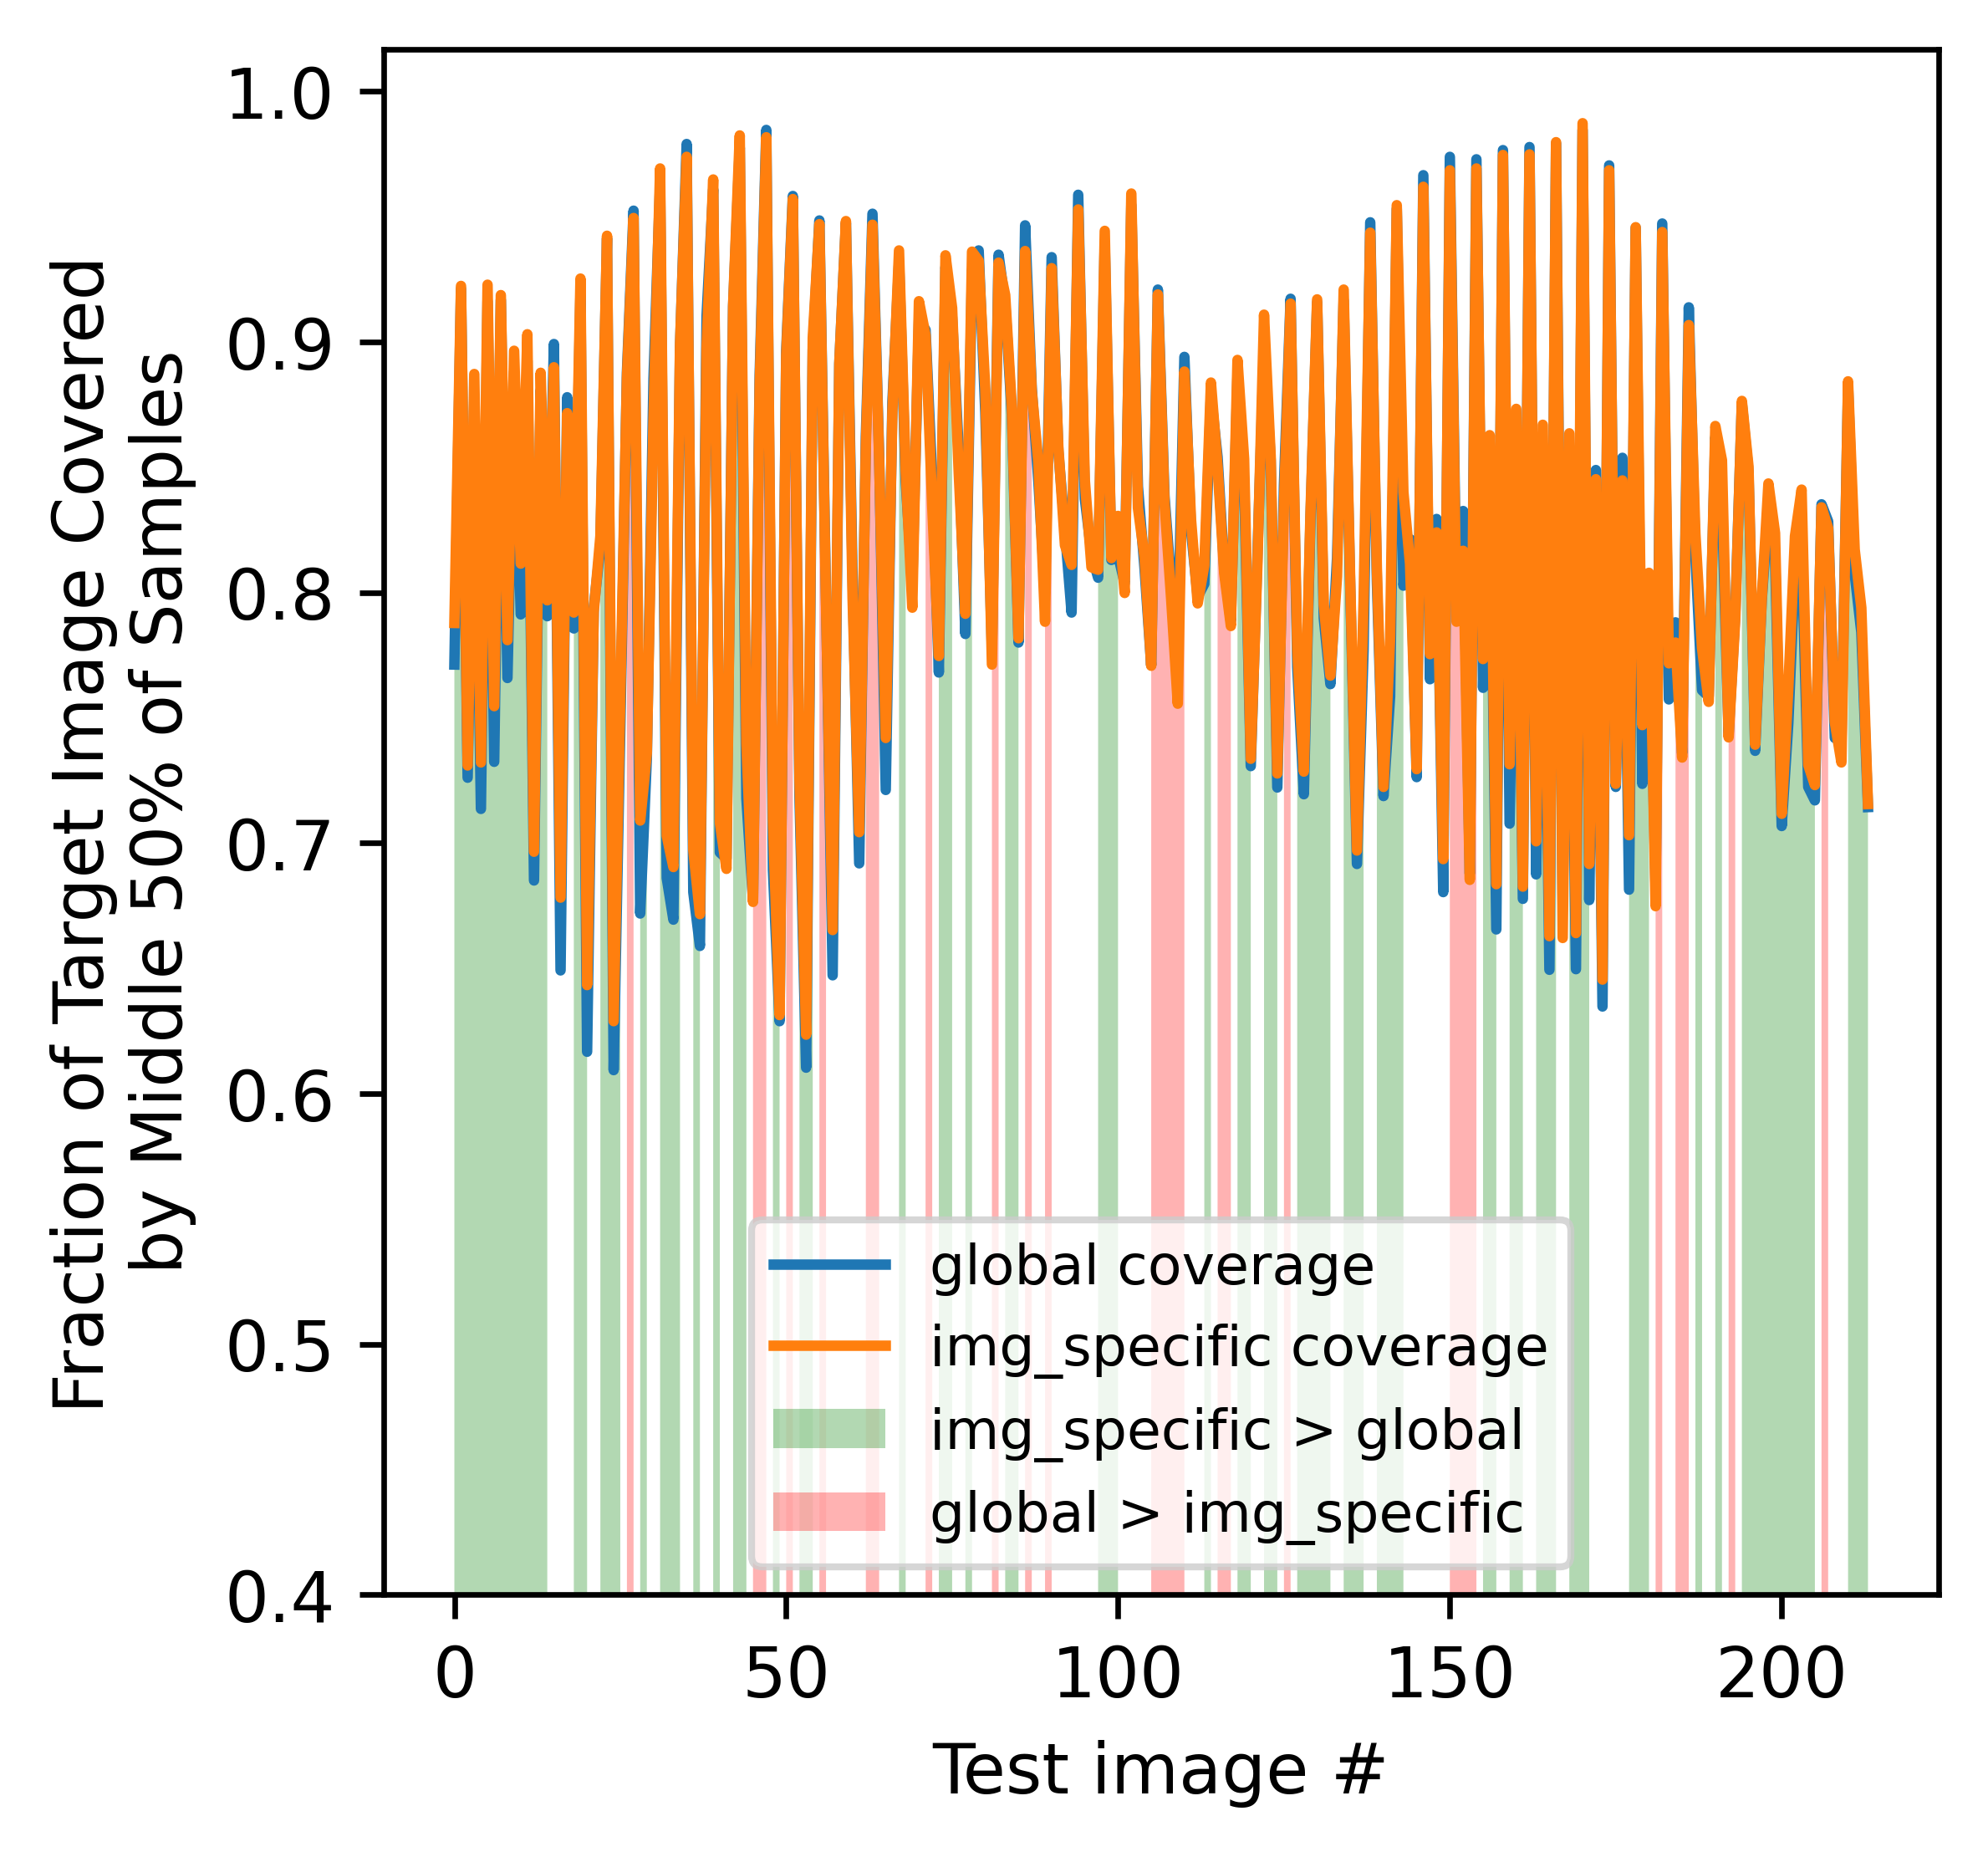

In [25]:
x = np.arange(len(global_50_coverage))  # or your actual x-axis values

plt.figure(figsize=(4, 4), dpi=600)

# Plot the curves
plt.plot(x, global_50_coverage, label='global coverage', color='C0')
plt.plot(x, p5p5_50_coverage, label='img_specific coverage', color='C1')

plt.fill_between(
    x,
    0.4,
    p5p5_50_coverage,
    where=(p5p5_50_coverage > global_50_coverage),
    # interpolate=True,
    linewidth=0,
    color='green',
    alpha=0.3,
    label='img_specific > global'
)

# Fill red where p5p5_50_coverage < global_50_coverage
plt.fill_between(
    x,
    0.4,
    p5p5_50_coverage,
    where=(p5p5_50_coverage <= global_50_coverage),
    # interpolate=True,
    linewidth=0,
    color='red',
    alpha=0.3,
    label='global > img_specific'
)

plt.xlabel('Test image #')
plt.ylabel('Fraction of Target Image Covered \n by Middle 50% of Samples')

plt.legend(loc='lower center', fontsize=8)
plt.ylim((0.4, plt.gca().get_ylim()[1]))

In [26]:
# Pad array if length is not divisible by 4
remainder = len(global_50_coverage) % 4
if remainder != 0:
    padding = 4 - remainder
    global_50_coverage = np.pad(global_50_coverage, (0, padding), constant_values=np.nan)  # or choose a padding method

# Reshape and reorder
reshaped = global_50_coverage.reshape(-1, 4)  # shape: (N, 4)
reordered_global_50_coverage = reshaped.T.flatten()  # take columns in order

# Optionally remove padding
reordered_global_50_coverage = reordered_global_50_coverage[~np.isnan(reordered_global_50_coverage)]  # only if you padded with NaNs

In [27]:
# Pad array if length is not divisible by 4
remainder = len(p5p5_50_coverage) % 4
if remainder != 0:
    padding = 4 - remainder
    p5p5_50_coverage = np.pad(p5p5_50_coverage, (0, padding), constant_values=np.nan)  # or choose a padding method

# Reshape and reorder
reshaped = p5p5_50_coverage.reshape(-1, 4)  # shape: (N, 4)
reordered_p5p5_50_coverage = reshaped.T.flatten()  # take columns in order

# Optionally remove padding
reordered_p5p5_50_coverage = reordered_p5p5_50_coverage[~np.isnan(reordered_p5p5_50_coverage)]  # only if you padded with NaNs

(0.4, 1.016669921875)

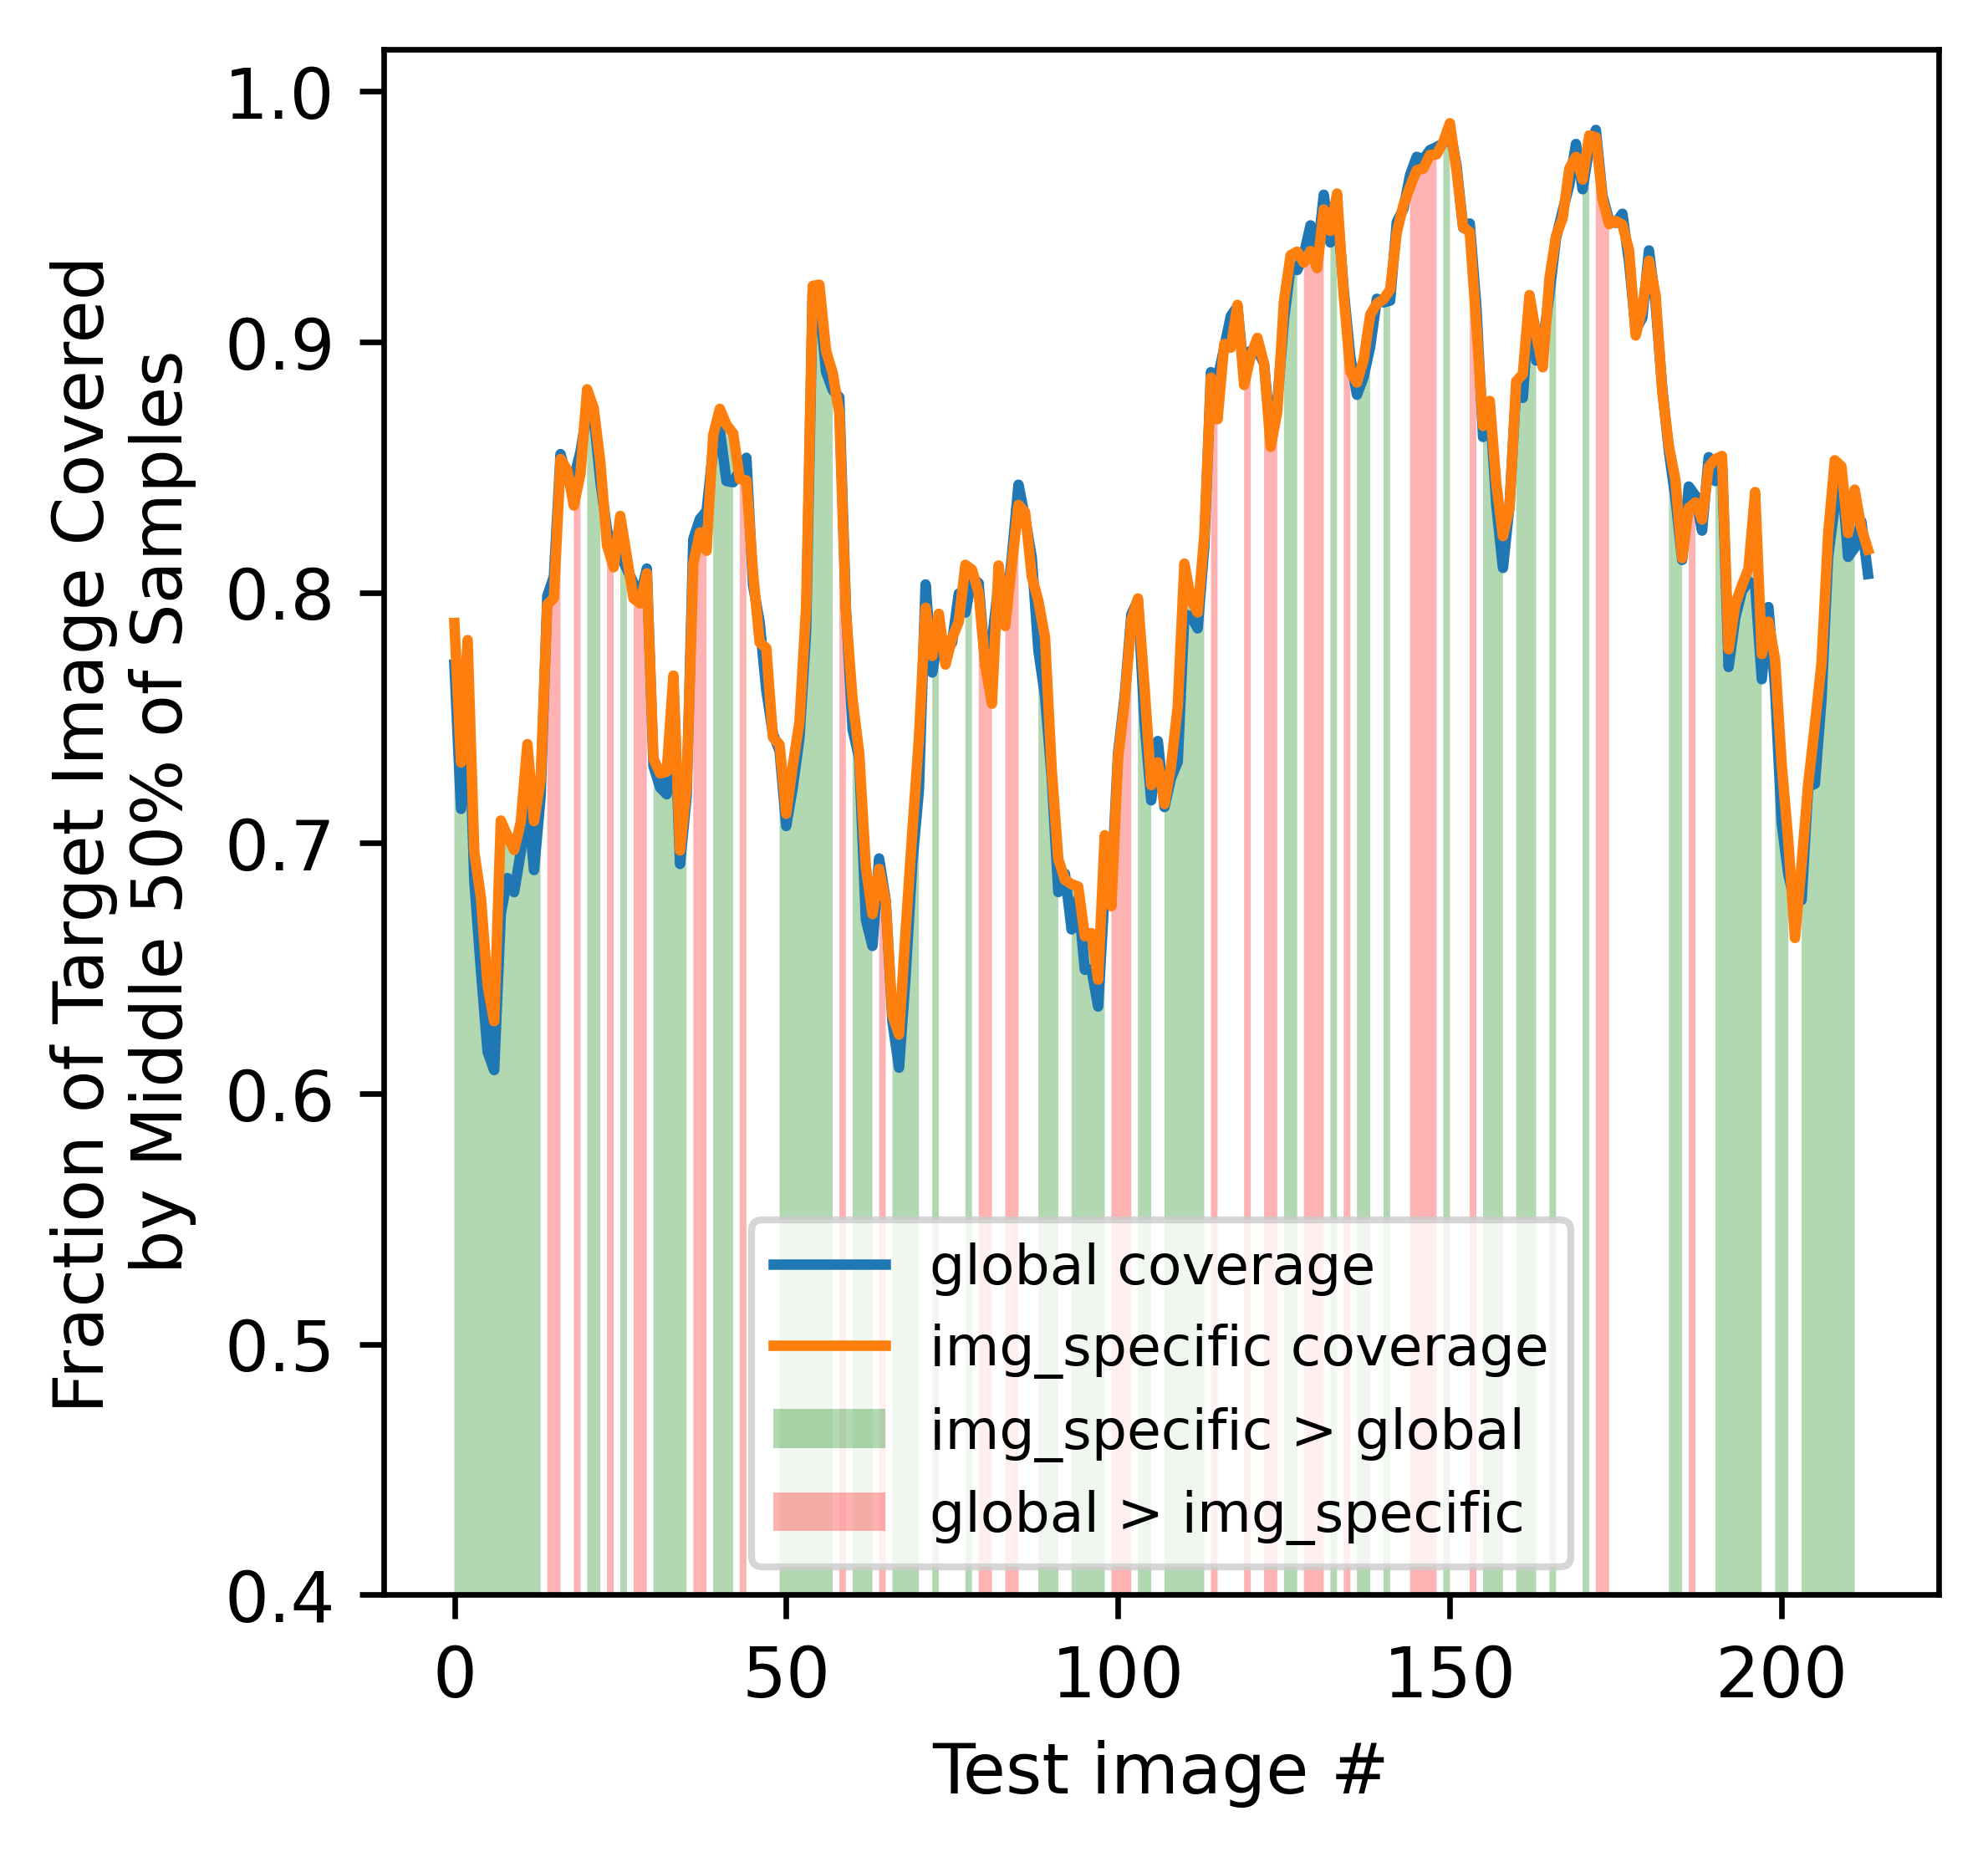

In [28]:
x = np.arange(len(reordered_global_50_coverage))  # or your actual x-axis values

plt.figure(figsize=(4, 4), dpi=600)

# Plot the curves
plt.plot(x, reordered_global_50_coverage, label='global coverage', color='C0')
plt.plot(x, reordered_p5p5_50_coverage, label='img_specific coverage', color='C1')

plt.fill_between(
    x,
    0.4,
    reordered_p5p5_50_coverage,
    where=(reordered_p5p5_50_coverage > reordered_global_50_coverage),
    # interpolate=True,
    linewidth=0,
    color='green',
    alpha=0.3,
    label='img_specific > global'
)

# Fill red where reordered_p5p5_50_coverage < reordered_global_50_coverage
plt.fill_between(
    x,
    0.4,
    reordered_p5p5_50_coverage,
    where=(reordered_p5p5_50_coverage <= reordered_global_50_coverage),
    # interpolate=True,
    linewidth=0,
    color='red',
    alpha=0.3,
    label='global > img_specific'
)

plt.xlabel('Test image #')
plt.ylabel('Fraction of Target Image Covered \n by Middle 50% of Samples')

plt.legend(loc='lower center', fontsize=8)
plt.ylim((0.4, plt.gca().get_ylim()[1]))

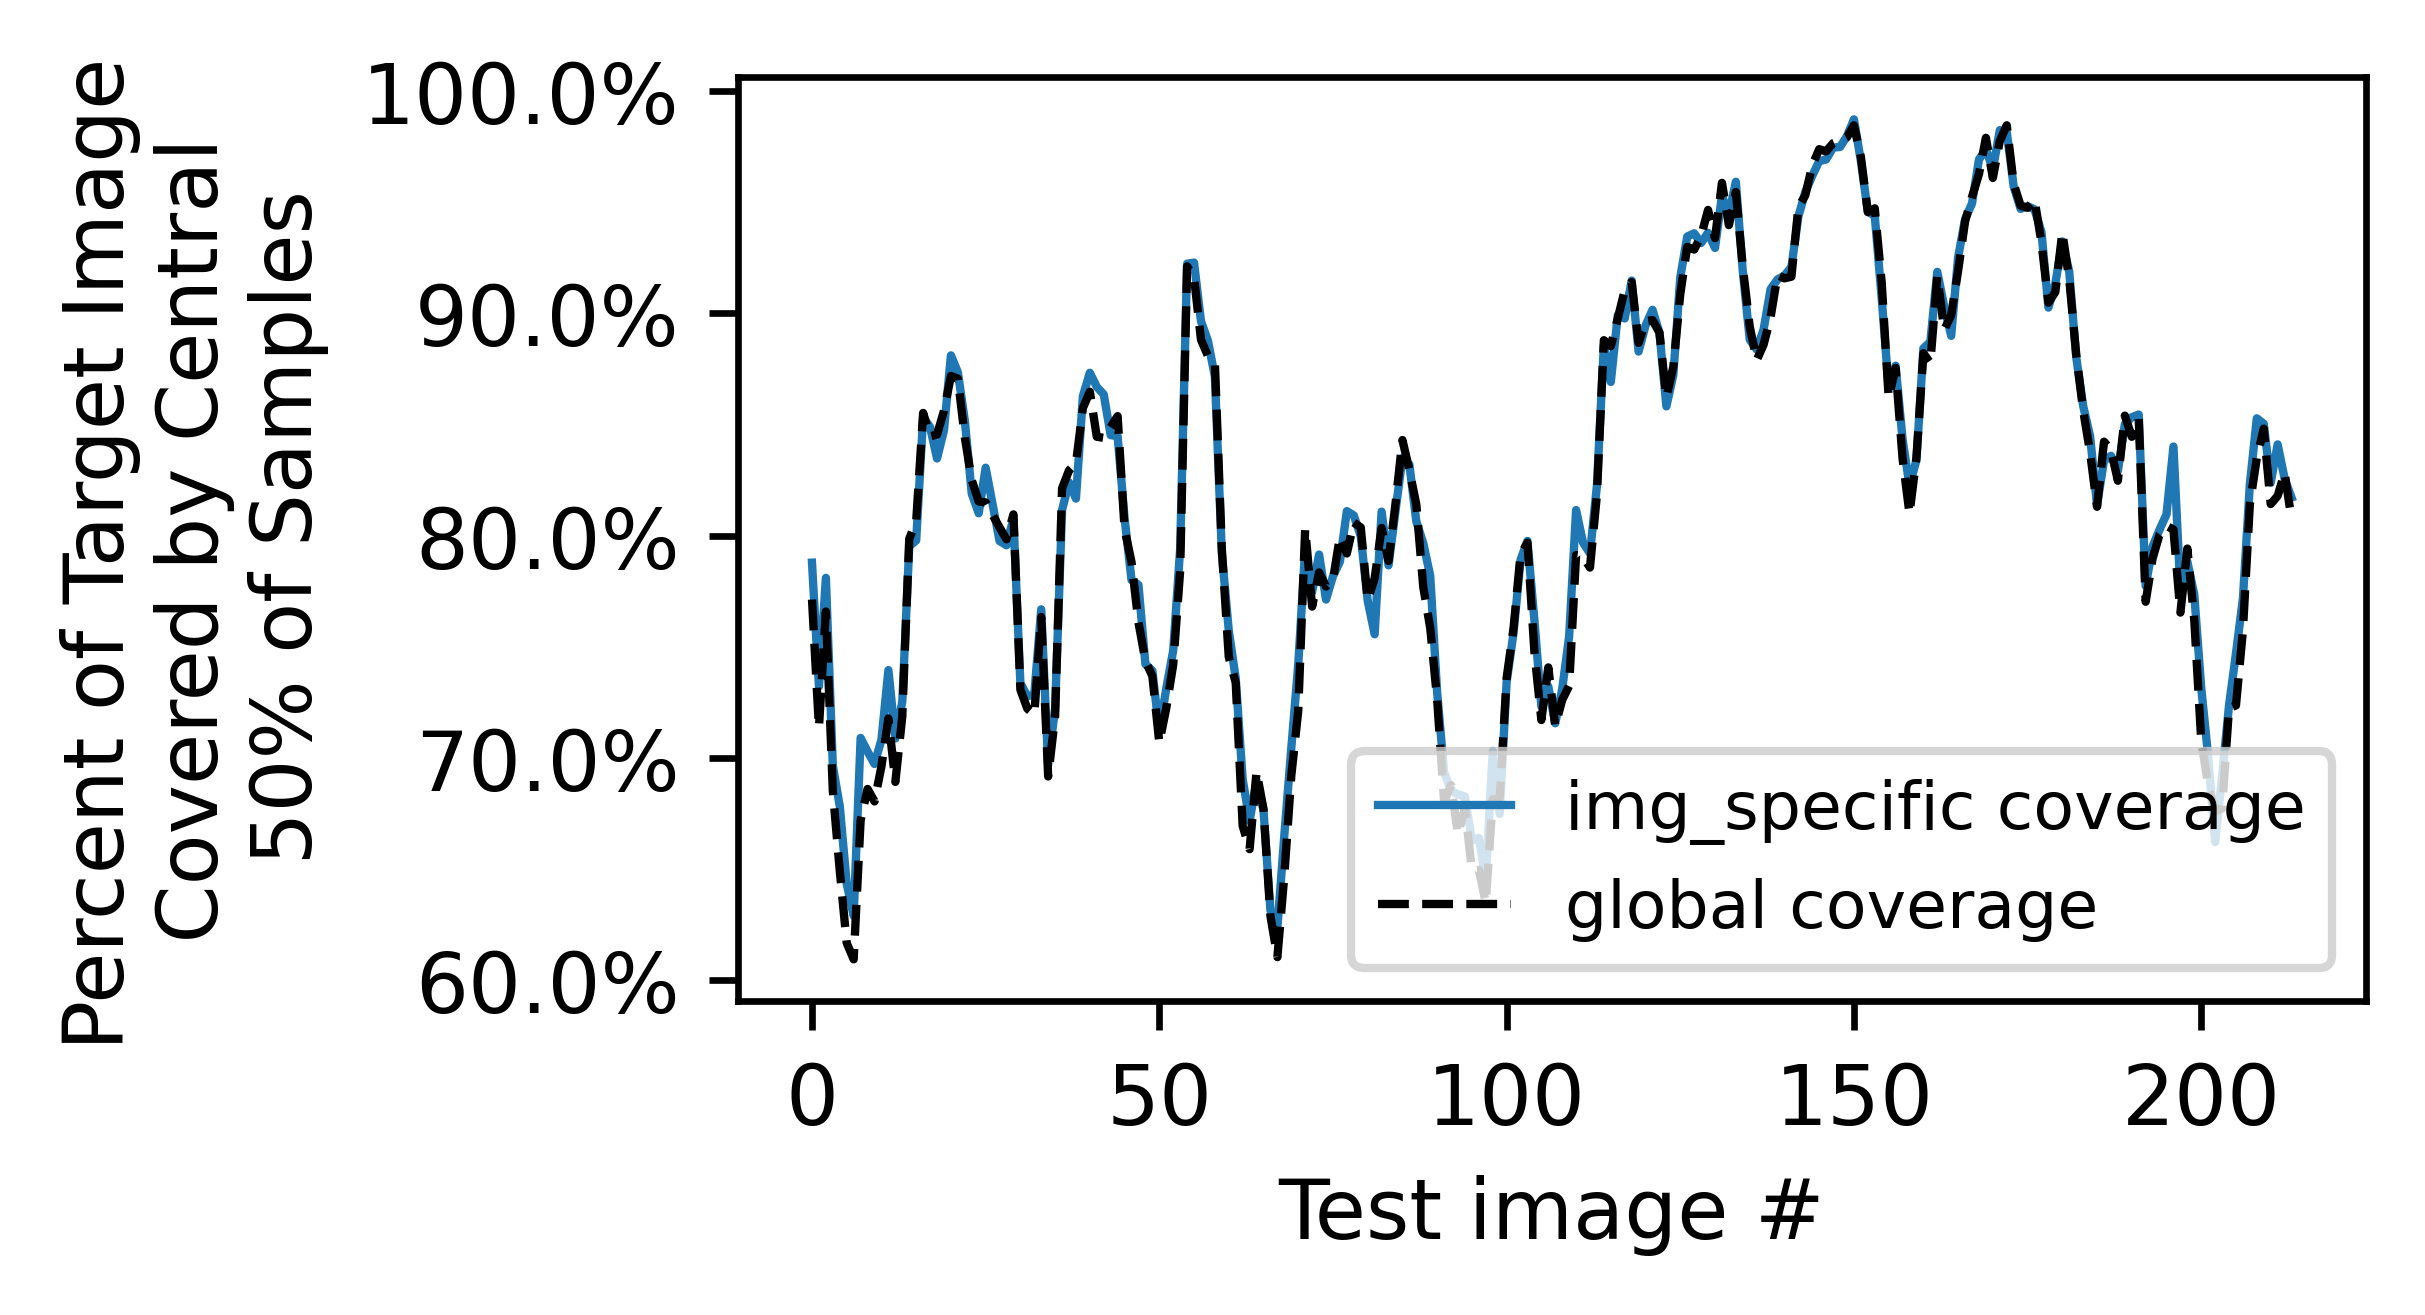

In [50]:
from matplotlib.ticker import PercentFormatter

x = np.arange(len(reordered_global_50_coverage))  # or your actual x-axis values

plt.figure(figsize=(3.5, 2), dpi=600)

# Plot the curves
plt.plot(x, reordered_p5p5_50_coverage, label='img_specific coverage', color='C0',
         ls='-', 
         lw=1,
        #  marker='.',
         )
plt.plot(x, reordered_global_50_coverage, label='global coverage', 
         ls='--', 
         lw=1,
        #  marker='.',
         color='k')


plt.xlabel('Test image #')
plt.ylabel('Percent of Target Image \n Covered by Central \n 50% of Samples')

plt.legend(
    # loc='lower center', 
    fontsize=8
    )


plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # xmax=1 assumes y-values in [0, 1]


In [120]:
np.sort(-depths)

array([-0.37372687, -0.36869041, -0.36752819, -0.36581258, -0.36458166,
       -0.36346793, -0.36290055, -0.36244287, -0.36199961, -0.35966223,
       -0.35965344, -0.3595297 , -0.35932889, -0.35915421, -0.35882913,
       -0.3582017 , -0.35797315, -0.35777491, -0.35744365, -0.35661464,
       -0.35643336, -0.35621442, -0.35586846, -0.35541358, -0.35518966,
       -0.35515473, -0.35507359, -0.35489555, -0.35486418, -0.35475823,
       -0.3539139 , -0.35374574, -0.35243392, -0.3522235 , -0.35221841,
       -0.35220263, -0.35142532, -0.35133617, -0.35127108, -0.35117209,
       -0.35084434, -0.35071394, -0.35054808, -0.35038601, -0.3503525 ,
       -0.34903931, -0.34875788, -0.34856929, -0.34816398, -0.34769784,
       -0.34765727, -0.34764931, -0.34763683, -0.34724182, -0.34711316,
       -0.34666938, -0.34666391, -0.34621113, -0.34603568, -0.34524161,
       -0.34520092, -0.34507899, -0.34477163, -0.34476808, -0.34436543,
       -0.3443484 , -0.34430514, -0.34416178, -0.34409349, -0.34

In [122]:
surfaces.shape

(50, 64, 64, 1)

In [123]:
global_90_coverage = []
p2p5_90_coverage = []

depth_idx_max = 90

path_to_img_spec_noise = "/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/notebooks/covariance_subroutine/sample_data/from_kestrel/"

for i in range(targets.shape[0]):
    print(i)

    #### Get GLOBAL result
    ## resample noise
    g_noise = get_noise_from_cov_params_wSVD(global_u, global_s, n_samples=100)
    
    g_samples = g_noise + global_pred[i].ravel()[None, :]
    
    ## Compute surfaces
    fd = FDataGrid(g_samples.reshape((-1, hr_data_size, hr_data_size)))
    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 90% deepest)
    # n = len(fd)
    central_region_indices = np.argsort(-depths)[:depth_idx_max]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    global_90_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    ## Get IMG-SPE result
    is_noise = np.load(path_to_img_spec_noise + f"p2p5_img_{599+i}_noise_samples.npy") 
    is_samples = p2p5_pred[i].ravel()[None, :] + is_noise
    
    fd = FDataGrid(is_samples.reshape((-1, hr_data_size, hr_data_size)))

    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 90% deepest)
    central_region_indices = np.argsort(-depths)[:depth_idx_max]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    p2p5_90_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


In [125]:
global_90_coverage = np.asarray(global_90_coverage)
p2p5_90_coverage = np.asarray(p2p5_90_coverage)

(0.4, 1.020771484375)

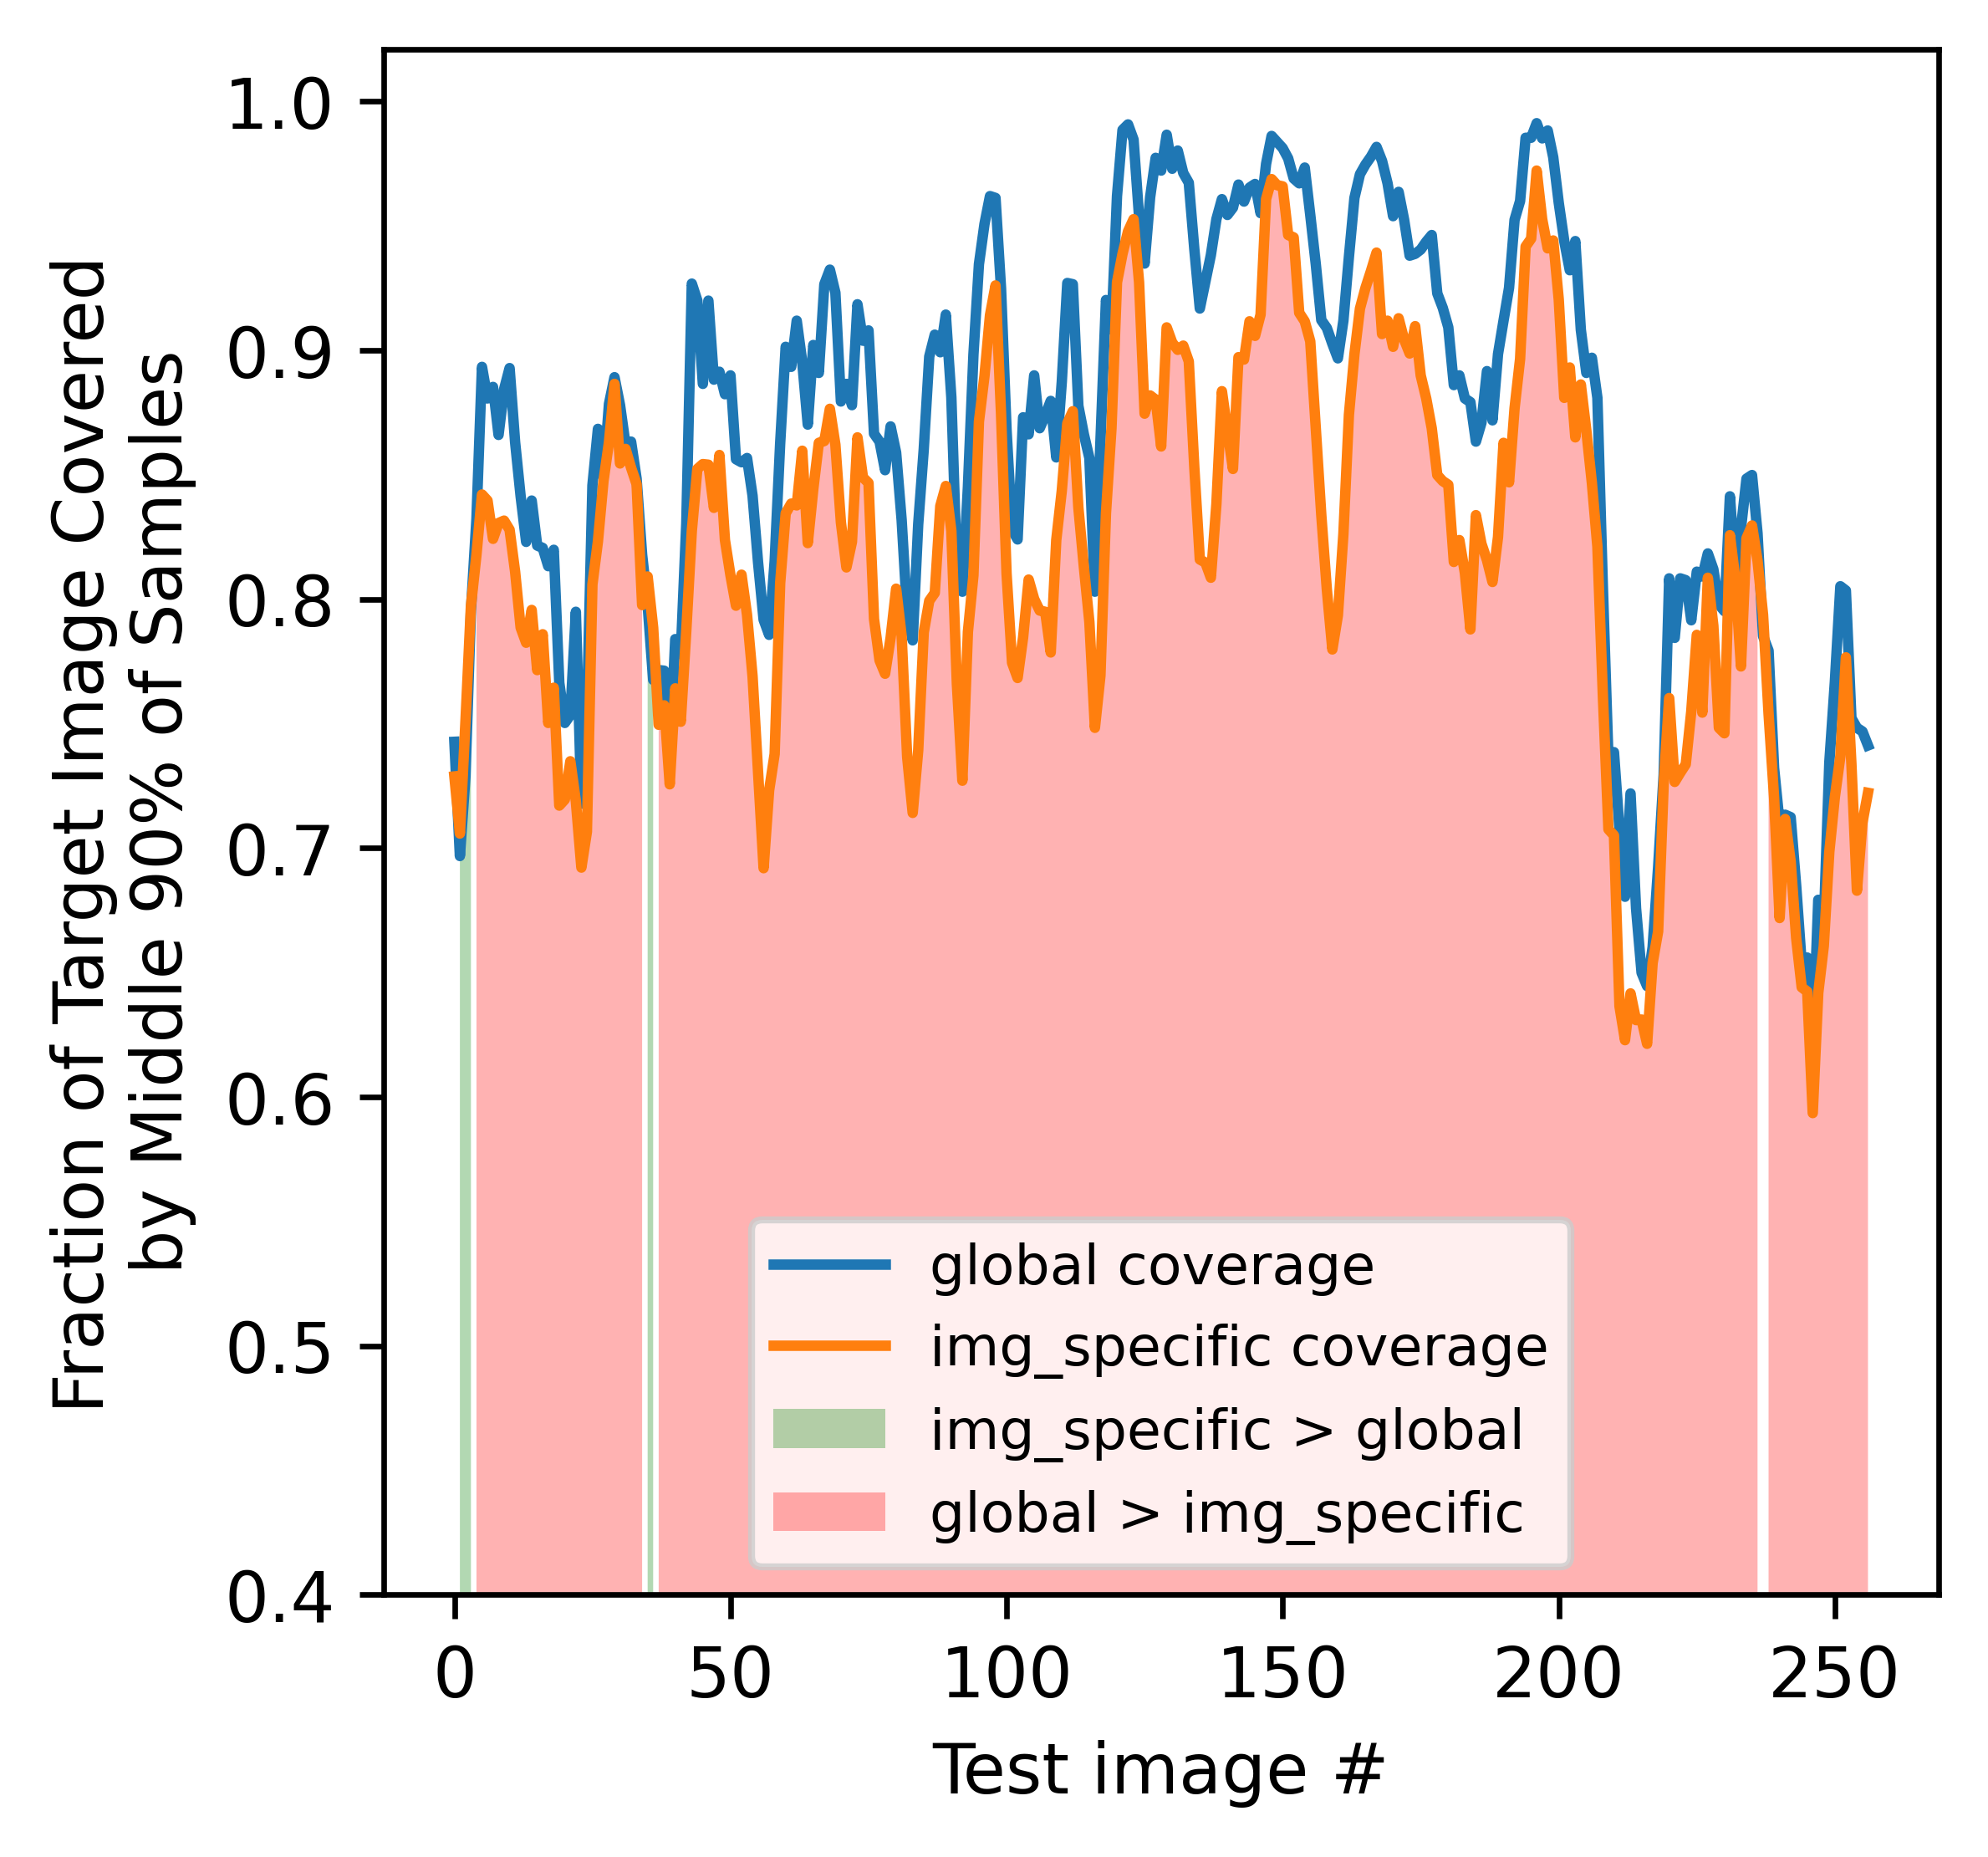

In [126]:
x = np.arange(len(global_90_coverage))  # or your actual x-axis values

plt.figure(figsize=(4, 4), dpi=600)

# Plot the curves
plt.plot(x, global_90_coverage, label='global coverage', color='C0')
plt.plot(x, p2p5_90_coverage, label='img_specific coverage', color='C1')

plt.fill_between(
    x,
    0.4,
    p2p5_90_coverage,
    where=(p2p5_90_coverage > global_90_coverage),
    # interpolate=True,
    linewidth=0,
    color='green',
    alpha=0.3,
    label='img_specific > global'
)

# Fill red where p2p5_90_coverage < global_90_coverage
plt.fill_between(
    x,
    0.4,
    p2p5_90_coverage,
    where=(p2p5_90_coverage <= global_90_coverage),
    # interpolate=True,
    linewidth=0,
    color='red',
    alpha=0.3,
    label='global > img_specific'
)

plt.xlabel('Test image #')
plt.ylabel('Fraction of Target Image Covered \n by Middle 90% of Samples')

plt.legend(loc='lower center', fontsize=8)
plt.ylim((0.4, plt.gca().get_ylim()[1]))

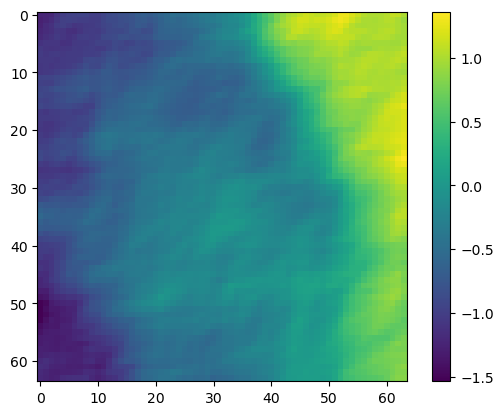

In [117]:
plt.imshow(is_samples[3].reshape((hr_data_size, hr_data_size)))
plt.colorbar()

In [90]:
## p4

In [95]:
p4_cov_params = np.load(
    "/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/scripts/" \
    "parCov_fitting/mse/params_from_kestrel/with_00_mode/" \
    "parCov_fitting_fourier_allImages_mseStart_globalPrior_anal_empPriorStdOn4_param_fits.npy"
    )


p4_err = np.load(
    "/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/scripts/" \
    "interp_upscale/HR_64x64/fourier_proj_cov/from_kestrel/with_00_mode/" \
    "fcov_GL_mseStart_gPAStdOn4_errFields.npy")

In [96]:
test_p4_cov_params = p4_cov_params[-257:]
test_p4_cov_params.shape

(257, 1089)

In [97]:
p4_pred = p4_err + targets

In [98]:
p4_pred.shape

(257, 64, 64)

In [100]:
global_coverage = []
imgspe_coverage = []

path_to_img_spec_noise = "/Users/hgoldwyn/Research/projects/SR_CNN/sr_cnn/real_data/torch/notebooks/covariance_subroutine/sample_data/from_kestrel/output/"

for i in range(targets.shape[0]):
    print(i)

    #### Get GLOBAL result
    ## resample noise
    g_noise = get_noise_from_cov_params_wSVD(global_u, global_s, n_samples=100)
    
    g_samples = g_noise + global_pred[i].ravel()[None, :]
    
    ## Compute surfaces
    fd = FDataGrid(g_samples.reshape((-1, hr_data_size, hr_data_size)))
    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    global_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    ## Get IMG-SPE result
    is_noise = np.load(path_to_img_spec_noise + f"p4_img_{599+i}_noise_samples.npy") 
    is_samples = p4_pred[i].ravel()[None, :] + is_noise
    
    fd = FDataGrid(is_samples.reshape((-1, hr_data_size, hr_data_size)))

    # Evaluate depths on the dataset
    depths = depth(fd)
    # Get index of the deepest (median) surface
    median_idx = np.argmax(depths)
    median_surface = fd[median_idx].data_matrix.squeeze()

    # Get central region (e.g., 50% deepest)
    n = len(fd)
    central_region_indices = np.argsort(-depths)[:n // 2]
    central_region = fd[central_region_indices]
    surfaces = central_region.data_matrix
    lower_surface = np.min(surfaces, axis=0)  # shape: (nx, ny)
    upper_surface = np.max(surfaces, axis=0)

    imgspe_coverage.append(np.logical_and(
        lower_surface.squeeze() < targets[i],
        upper_surface.squeeze() > targets[i]).sum() / hr_data_size**2
        )
    
    # if i == 10:
    #     break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256


In [101]:
global_coverage = np.asarray(global_coverage)
imgspe_coverage = np.asarray(imgspe_coverage)

(0.4, 1.01359375)

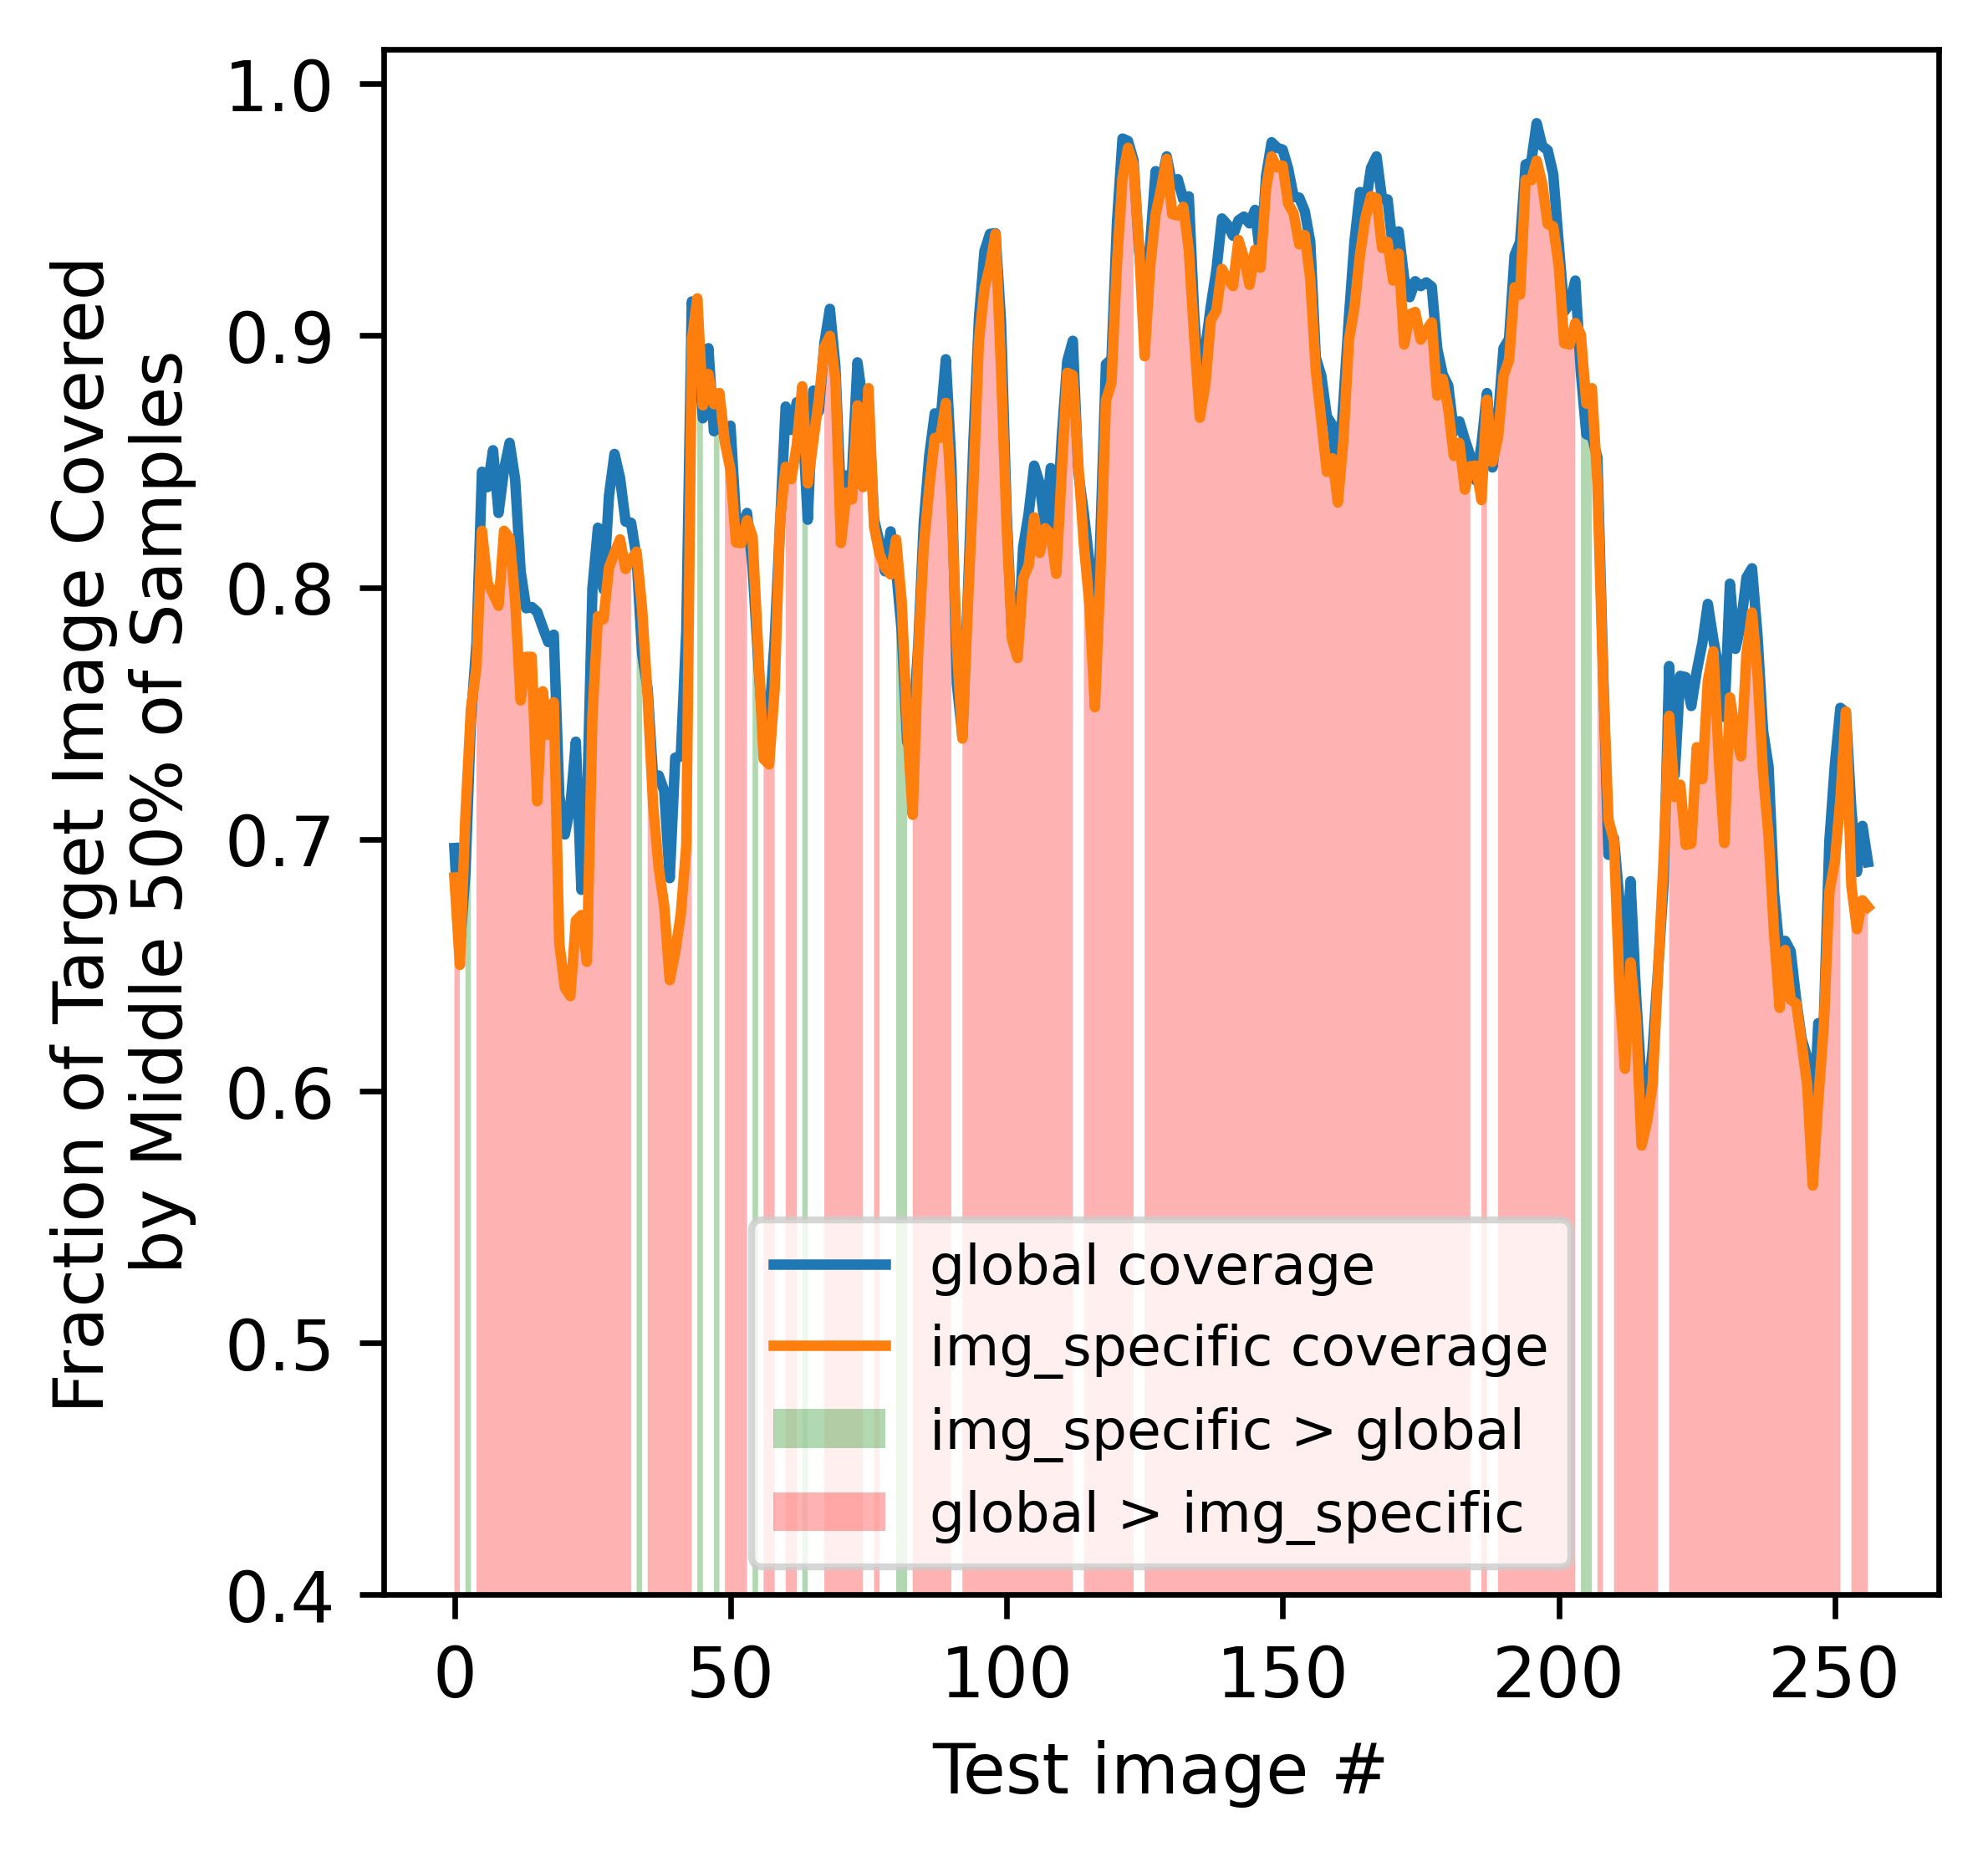

In [102]:
x = np.arange(len(global_coverage))  # or your actual x-axis values

plt.figure(figsize=(4, 4), dpi=600)

# Plot the curves
plt.plot(x, global_coverage, label='global coverage', color='C0')
plt.plot(x, imgspe_coverage, label='img_specific coverage', color='C1')

plt.fill_between(
    x,
    0.4,
    imgspe_coverage,
    where=(imgspe_coverage > global_coverage),
    # interpolate=True,
    linewidth=0,
    color='green',
    alpha=0.3,
    label='img_specific > global'
)

# Fill red where imgspe_coverage < global_coverage
plt.fill_between(
    x,
    0.4,
    imgspe_coverage,
    where=(imgspe_coverage <= global_coverage),
    # interpolate=True,
    linewidth=0,
    color='red',
    alpha=0.3,
    label='global > img_specific'
)

plt.xlabel('Test image #')
plt.ylabel('Fraction of Target Image Covered \n by Middle 50% of Samples')

plt.legend(loc='lower center', fontsize=8)
plt.ylim((0.4, plt.gca().get_ylim()[1]))

In [129]:
targets.shape

(257, 64, 64)

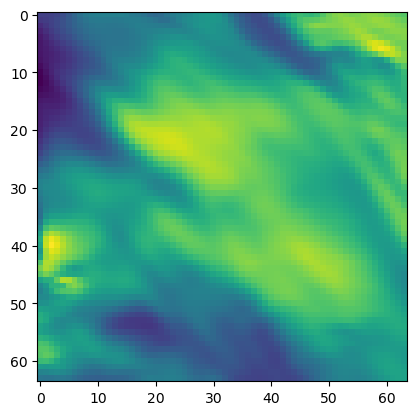

In [130]:
plt.imshow(targets[200])

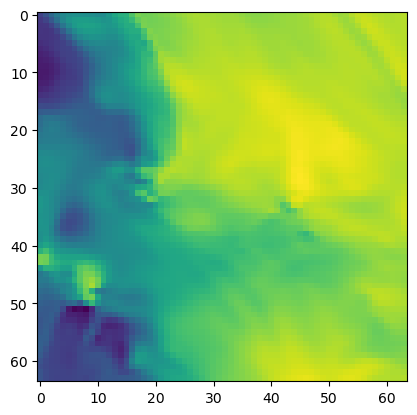

In [131]:
plt.imshow(targets[210])

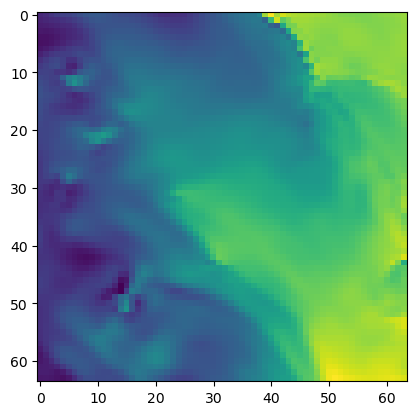

In [148]:
plt.imshow(targets[235])